<a href="https://colab.research.google.com/github/Adenugaabimbola/-GOAT-album/blob/main/Portfolio_analysis_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to analyze the historical stock price data of the current top ten technology firms based on mrket capitalization, simulate thousands of potential portfolios using the monte carlo simulation, and identify the optimal asset allocation based on the Sharpe Ratio. It implements core concepts from Modern Portfolio Theory (MPT), including expected return, volatility, and risk-adjusted return. I used a five-year historical dataset and tools such as pandas, numpy, yfinance, matplotlib, and seaborn.

1. Import libraries

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

2. Data Collection
Tickers Used:
- AAPL (Apple)
- MSFT (Microsoft)
- AMZN (Amazon)
- GOOGL (Alphabet)
- META (Meta Platforms)
- NVDA (NVIDIA)
- TSLA (Tesla)
- ORCL (ORACLE)
- AVGO (Broadcom)
- TSM (Taiwan Semiconductor Manufacturing)

Time Period:
Start: Five years before today
End: 27th June, 2025

Source:
yfinance library was used to download the historical stock price data.

In [ ]:
years = 5
end_date = dt.date.today().strftime("%Y-%m-%d")
start_date = (dt.date.today() - dt.timedelta(days=365*years)).strftime("%Y-%m-%d")
tickers = ["AAPL", "META", "GOOGL", "NVDA", "AMZN", "MSFT", "TSLA", "AVGO", "ORCL", "TSM"]
data = yf.download(tickers= tickers, start= start_date, end= end_date, progress=False, auto_adjust=False)
data = data.reset_index()
data.columns = ['Date'] + [f"{col[0]}_{col[1]}" for col in data.columns[1:]]

3. Data Cleaning & Preparation
Data Reshaping:
- The original multi-index DataFrame returned by yfinance for multiple tickers was flattened.
- melt and pivot_table were used to reshape data into long and tidy formats, making it suitable for visualizations and calculations.

Features Extracted:
- Close prices (used as proxy for actual trading price)
- Daily returns (percentage change in closing prices)
- Moving Averages were extracted

Processing Steps:
- Flatten column names for clarity.
- Reshape data using melt to get a long format.
- Separate Attribute and Ticker columns.
- Pivot to get a DataFrame with one row per ticker and date.

In [ ]:
data_melted = data.melt(id_vars = "Date", var_name = "Attribute_Ticker", value_name= "Price")
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.split('_', expand=True)
data_melted = data_melted[['Date', 'Ticker', 'Attribute', 'Price']]

data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Price', aggfunc='first')
stock_data = data_pivoted.reset_index()

4. Visual Analysis
Time Series Line Chart:
- Shows how each stock's closing price evolved over time.
- Used seaborn.lineplot for aesthetics and clarity.

Moving Averages:
- Plotted each stock's 50-day and 200-day moving averages alongside their daily close price to indicate momentum and potential buy/sell signals.

Volume Traded:
- Line graphs of volume data show the trading intensity over time.
Histogram of Daily Returns:
- For each stock, a histogram of daily returns was plotted.
- The hisogram was approximately like the normal distribution.
- Kernel Density Estimation (KDE) added for better visual understanding of return distribution.

Correlation Matrix:
- Heatmap showing pairwise correlations of daily returns.
- Helps assess diversification benefits across assets.

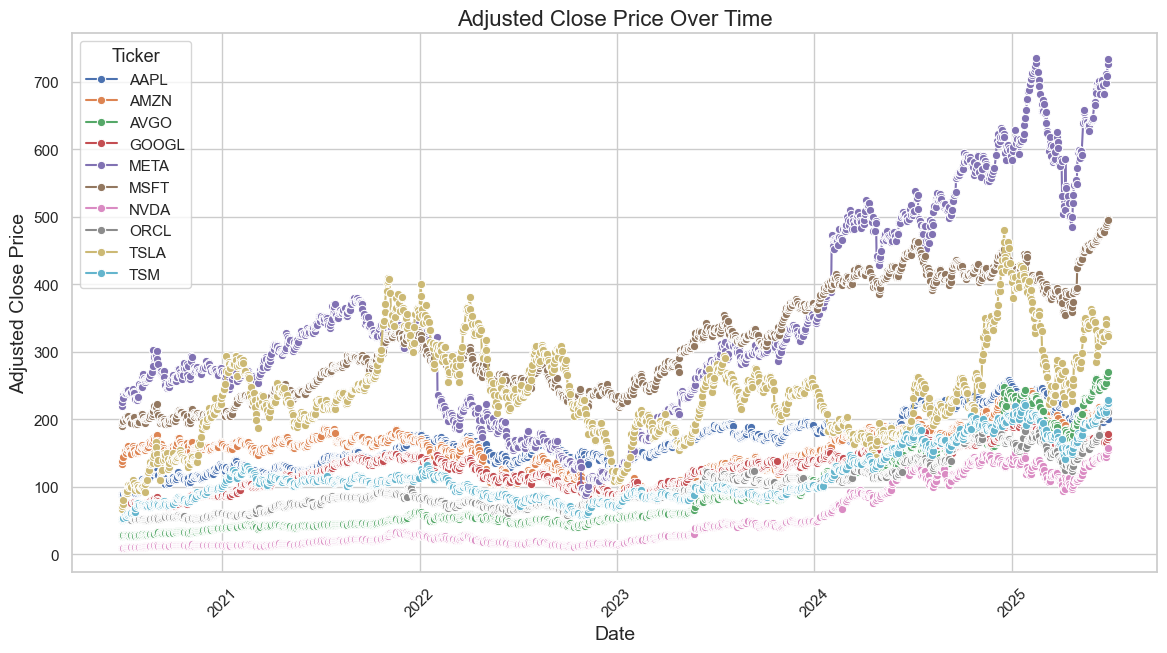

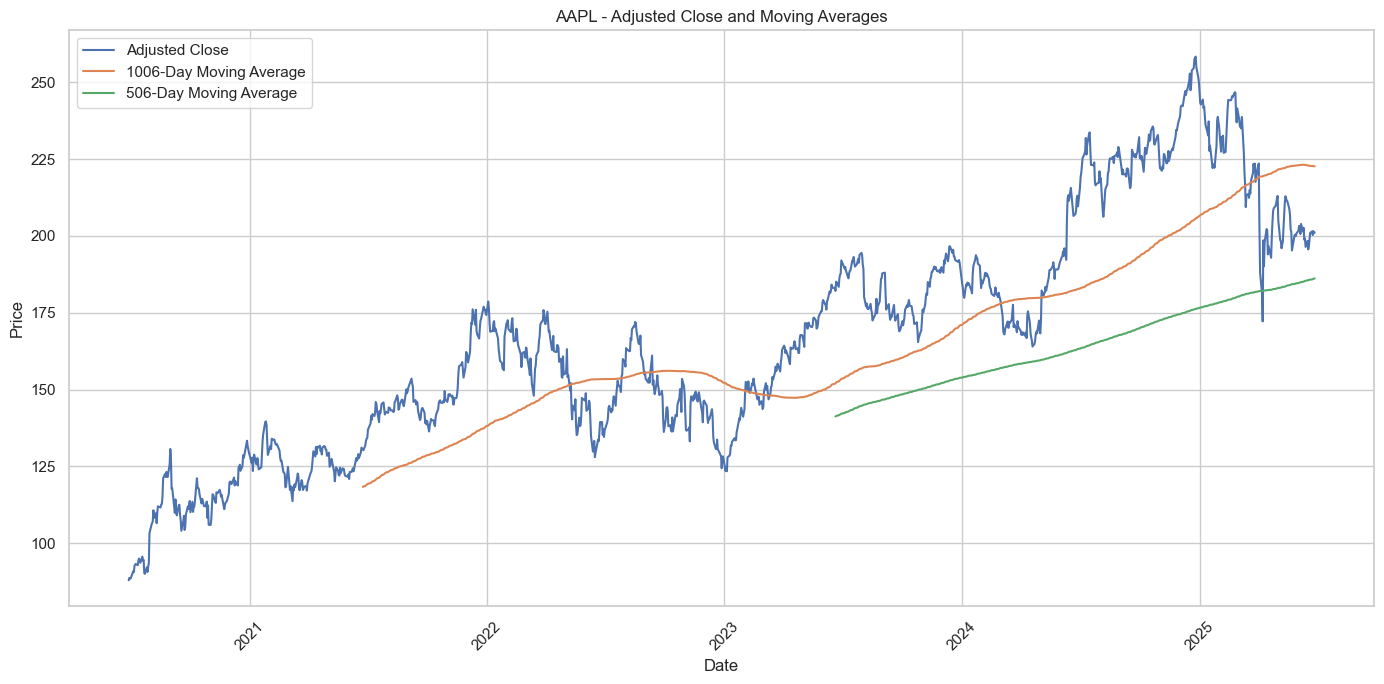

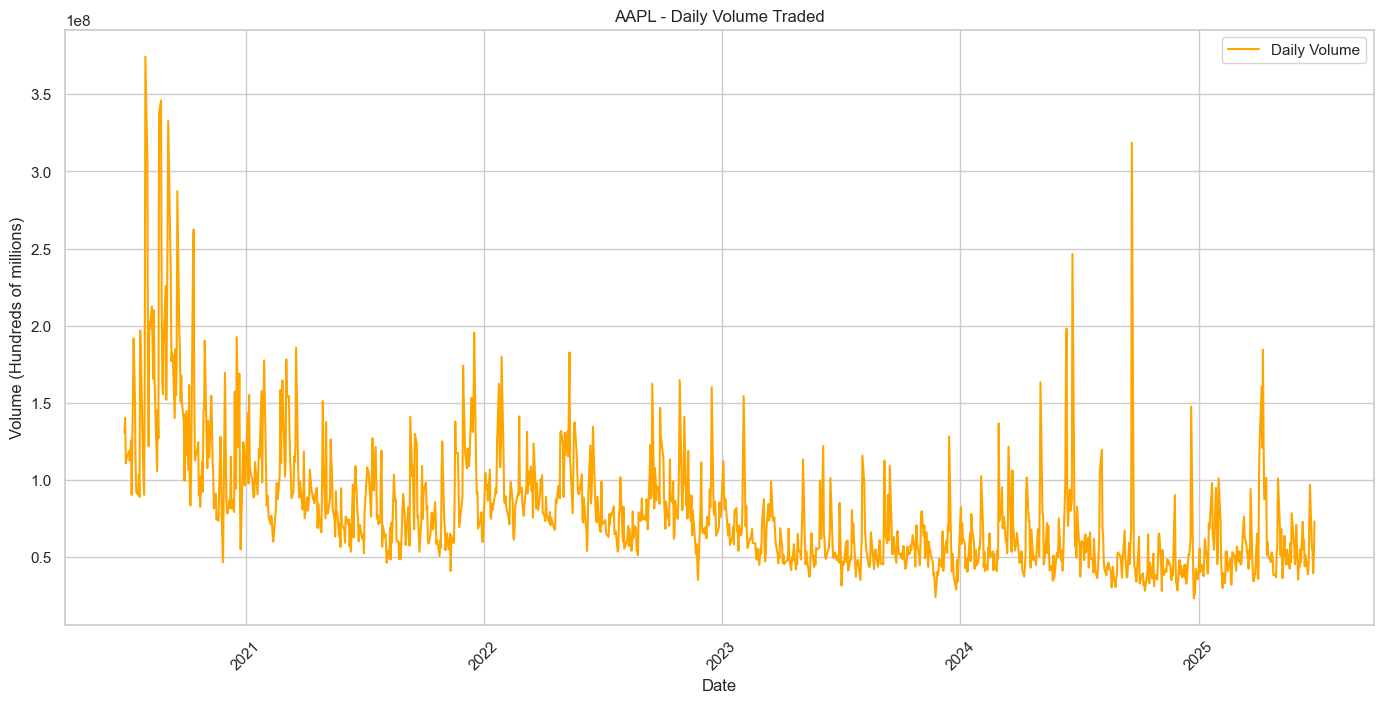

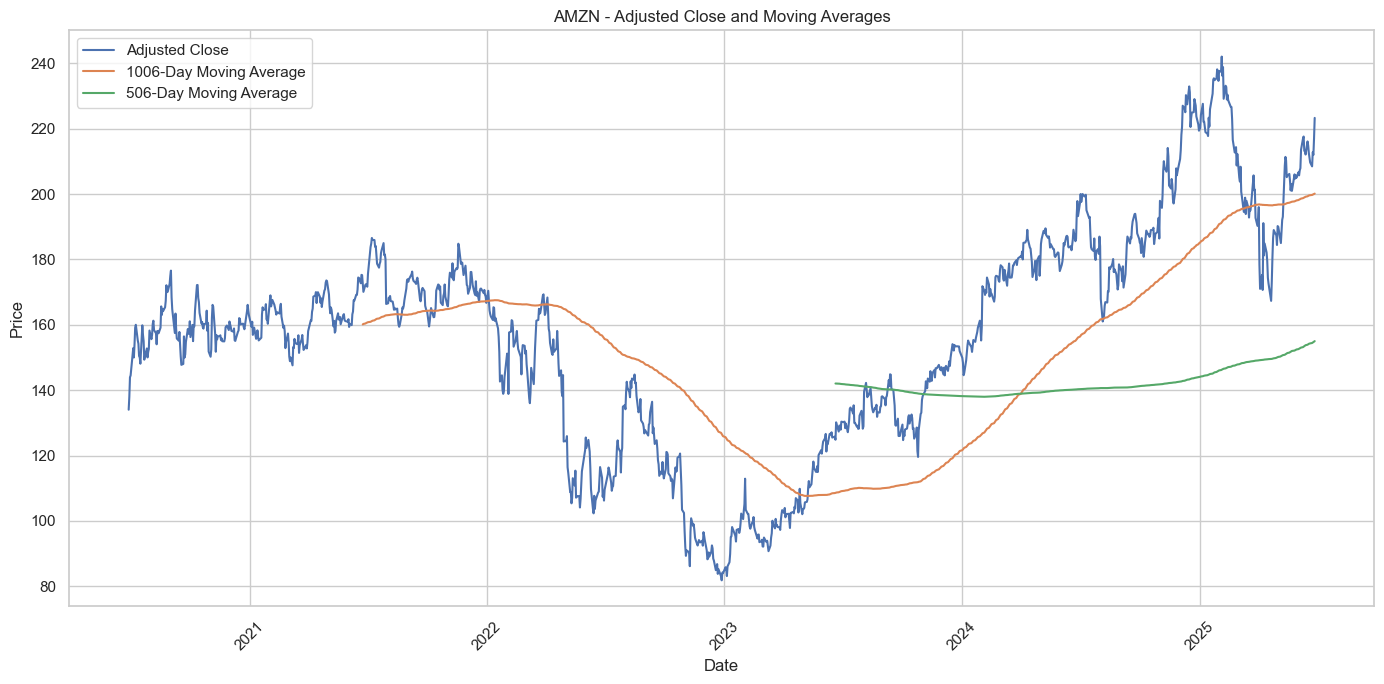

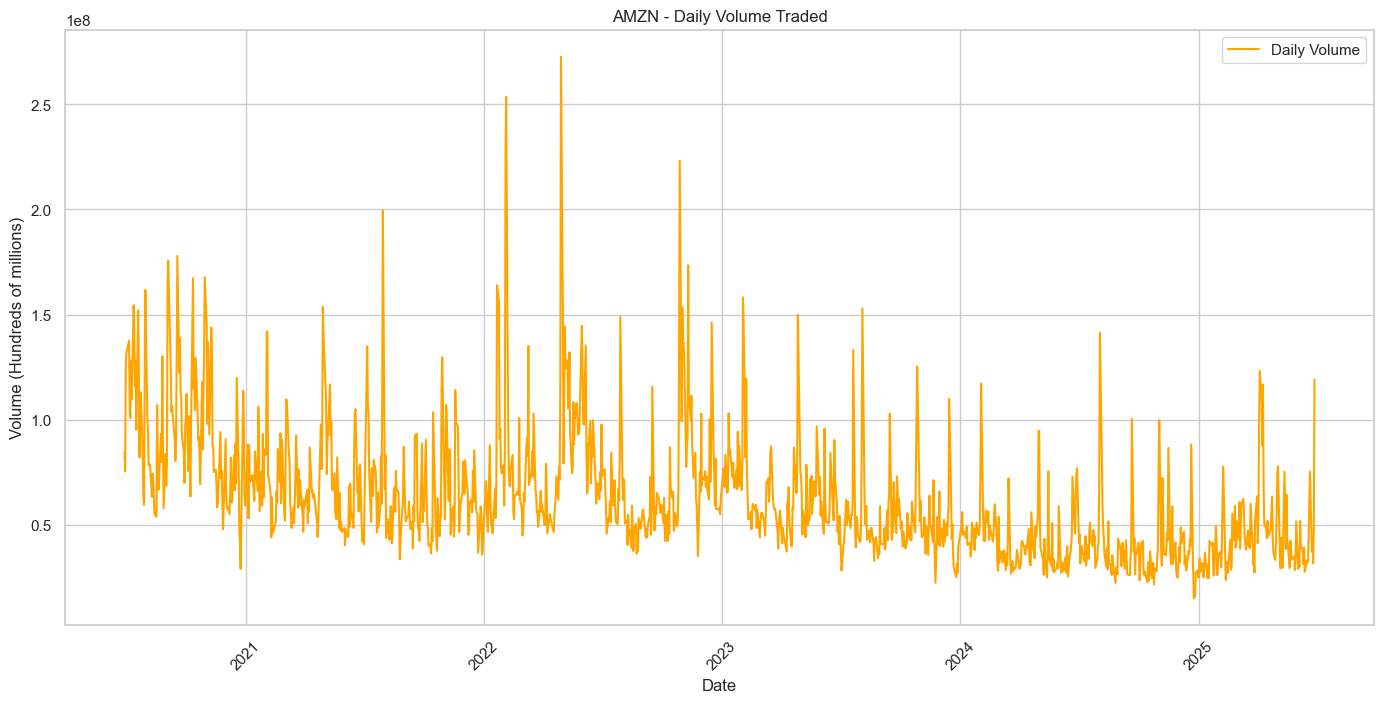

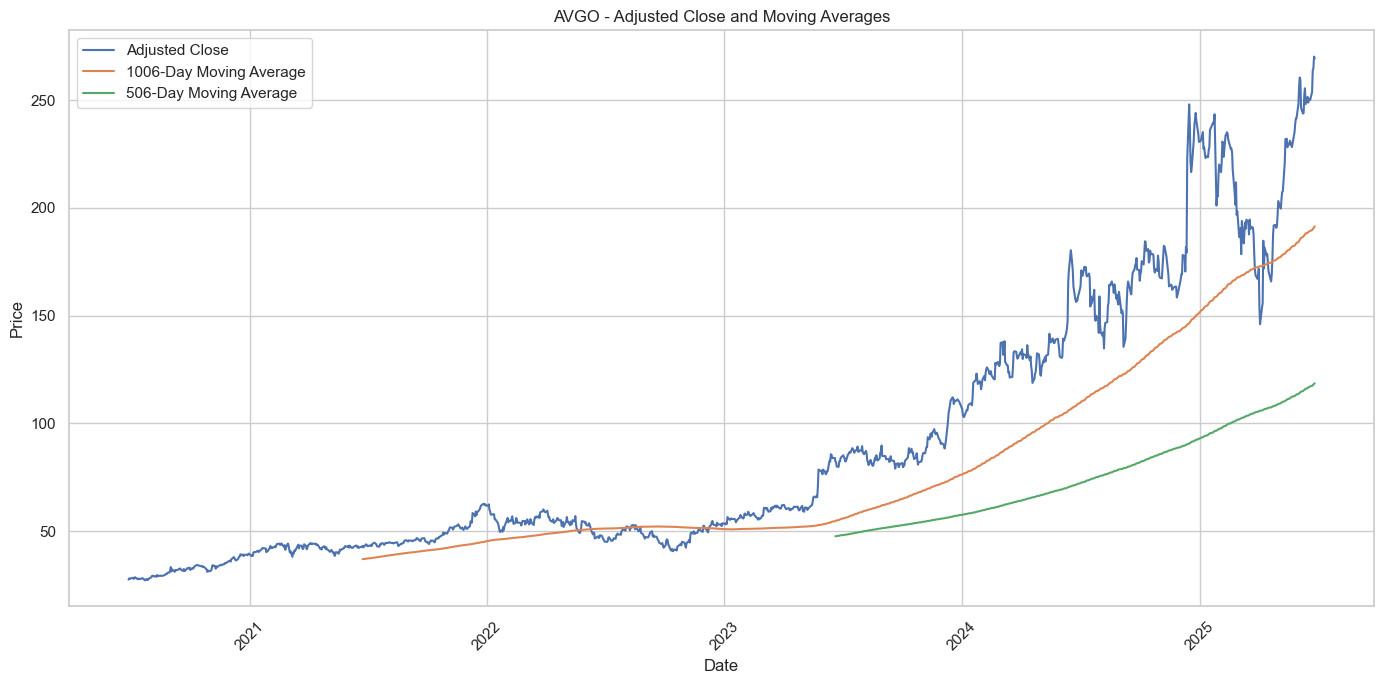

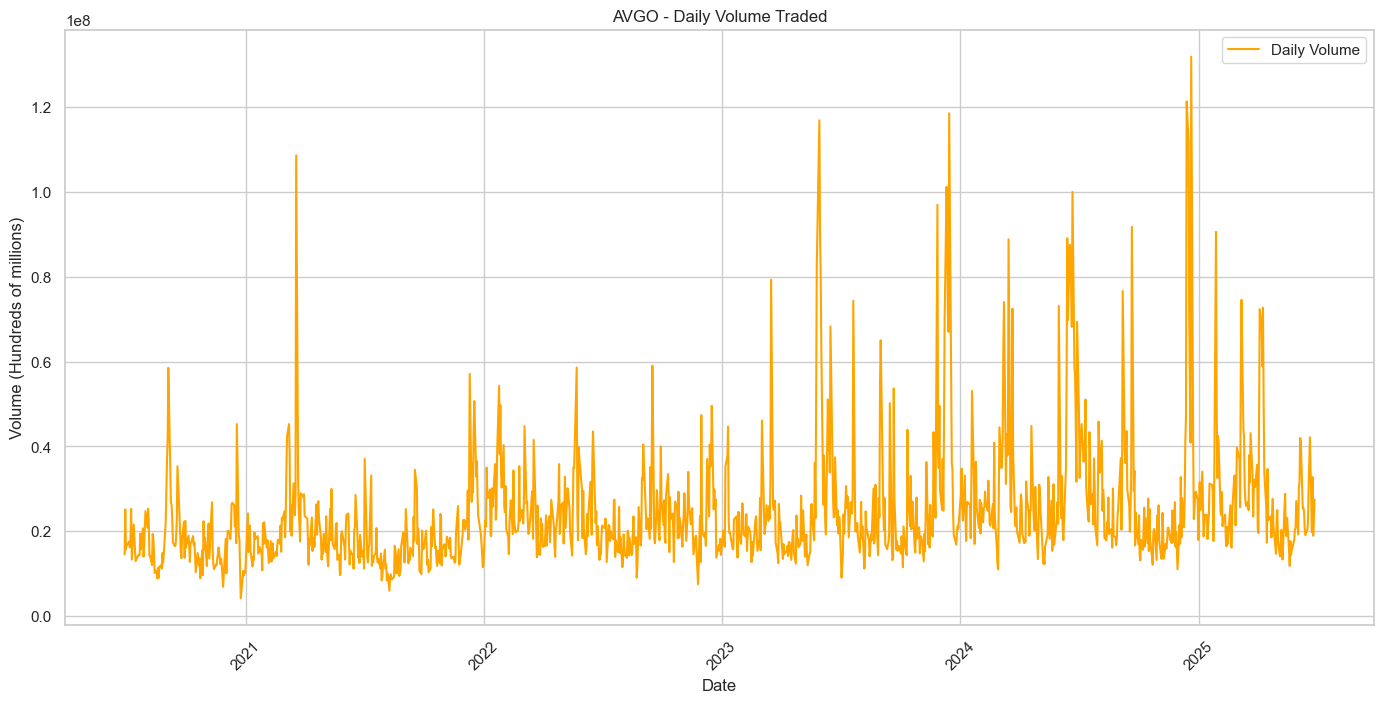

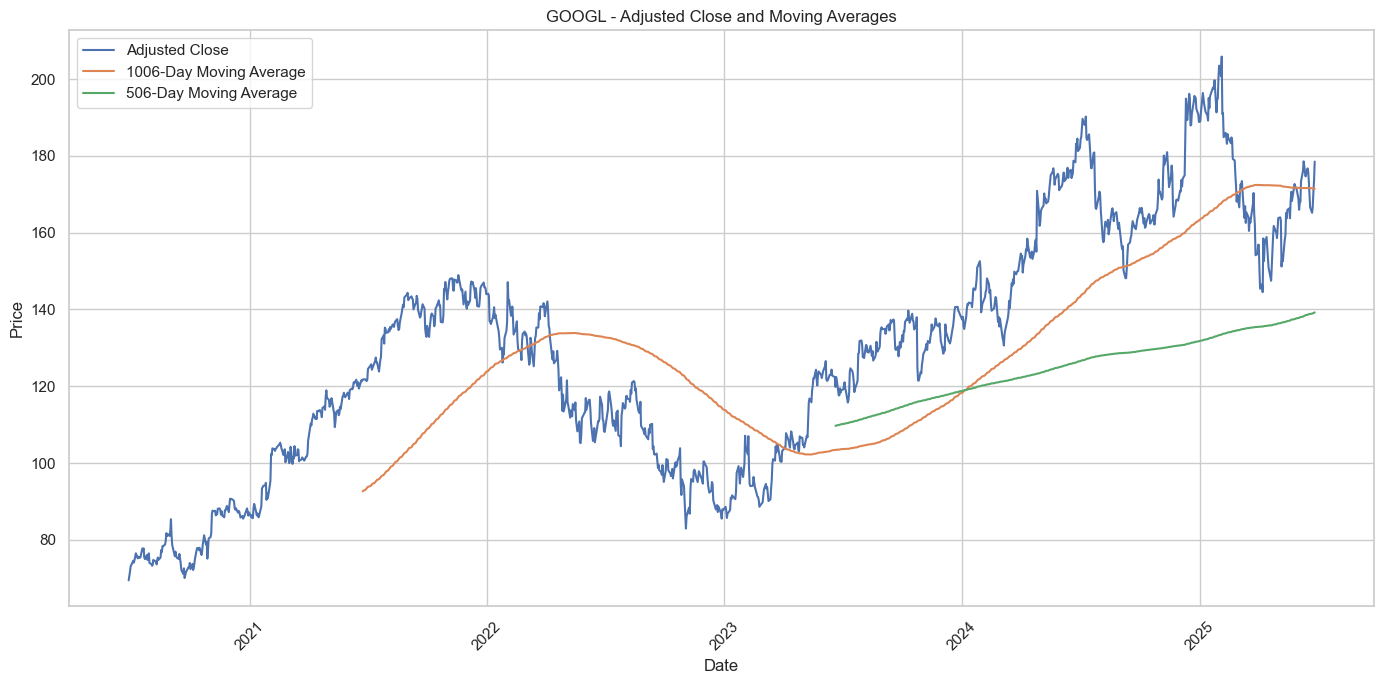

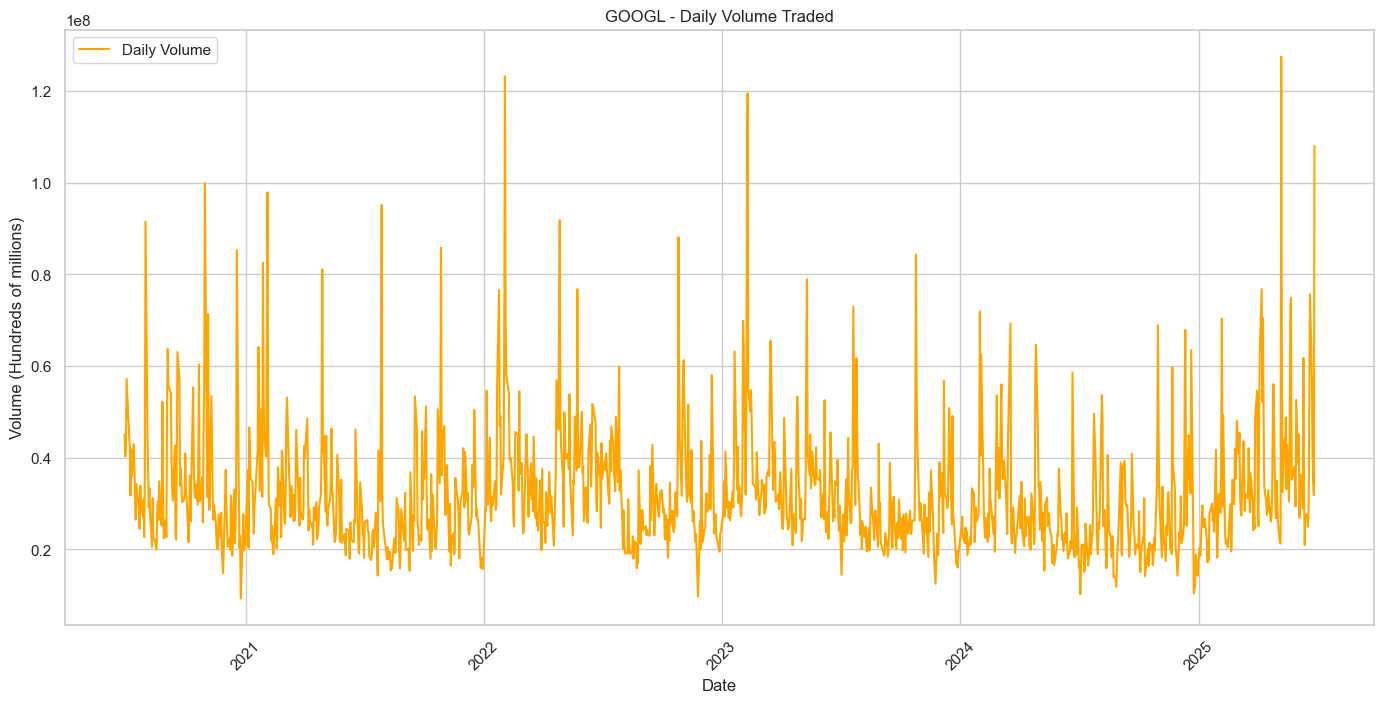

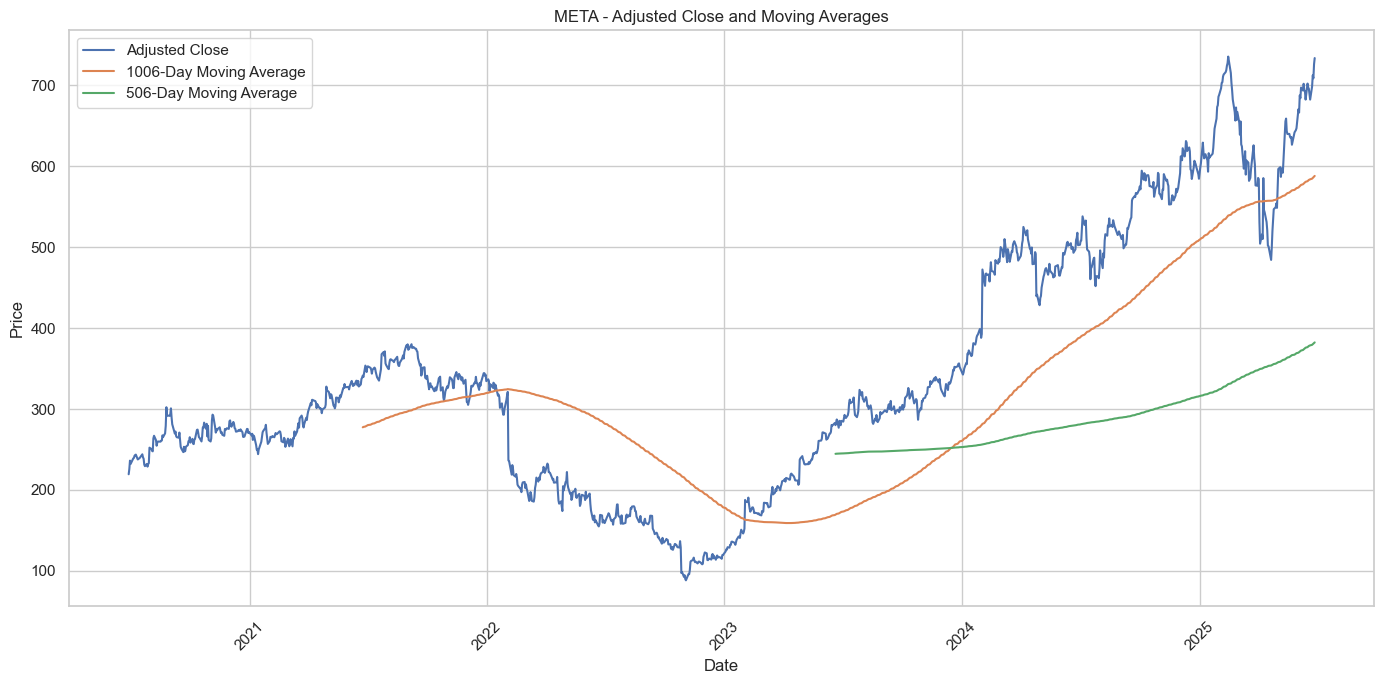

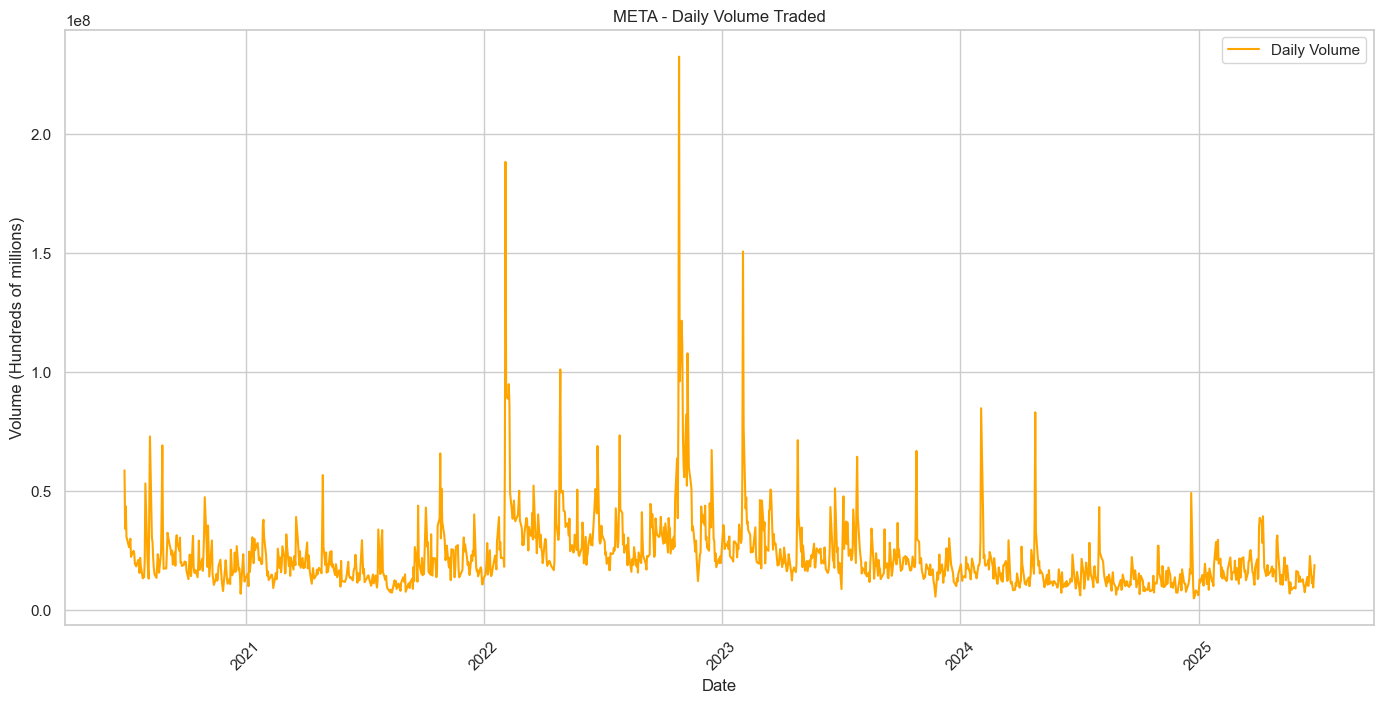

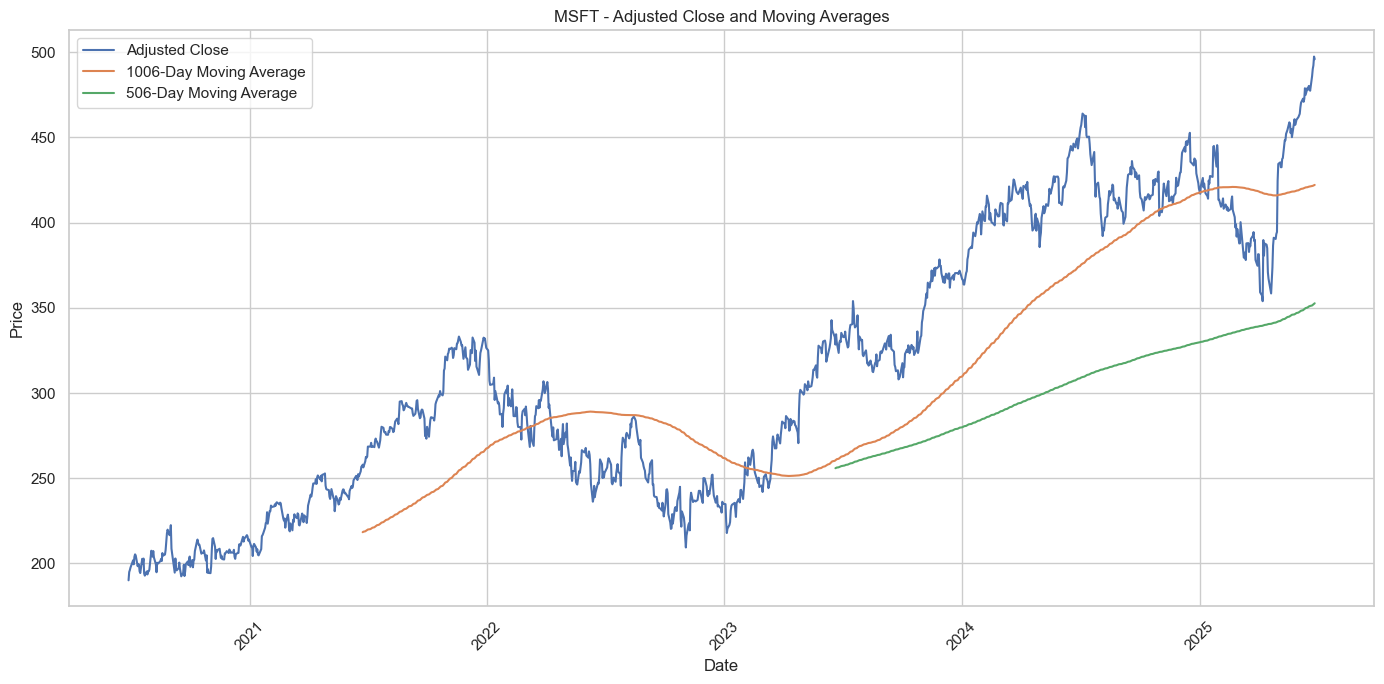

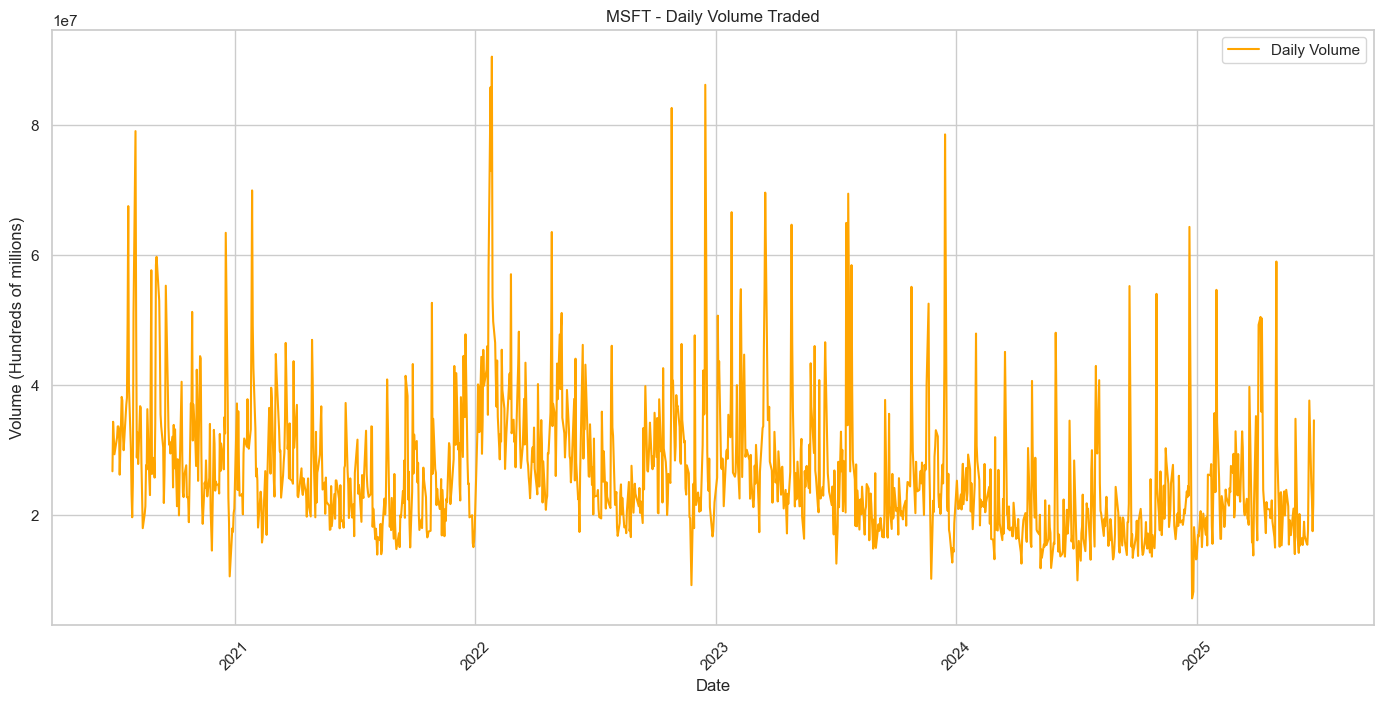

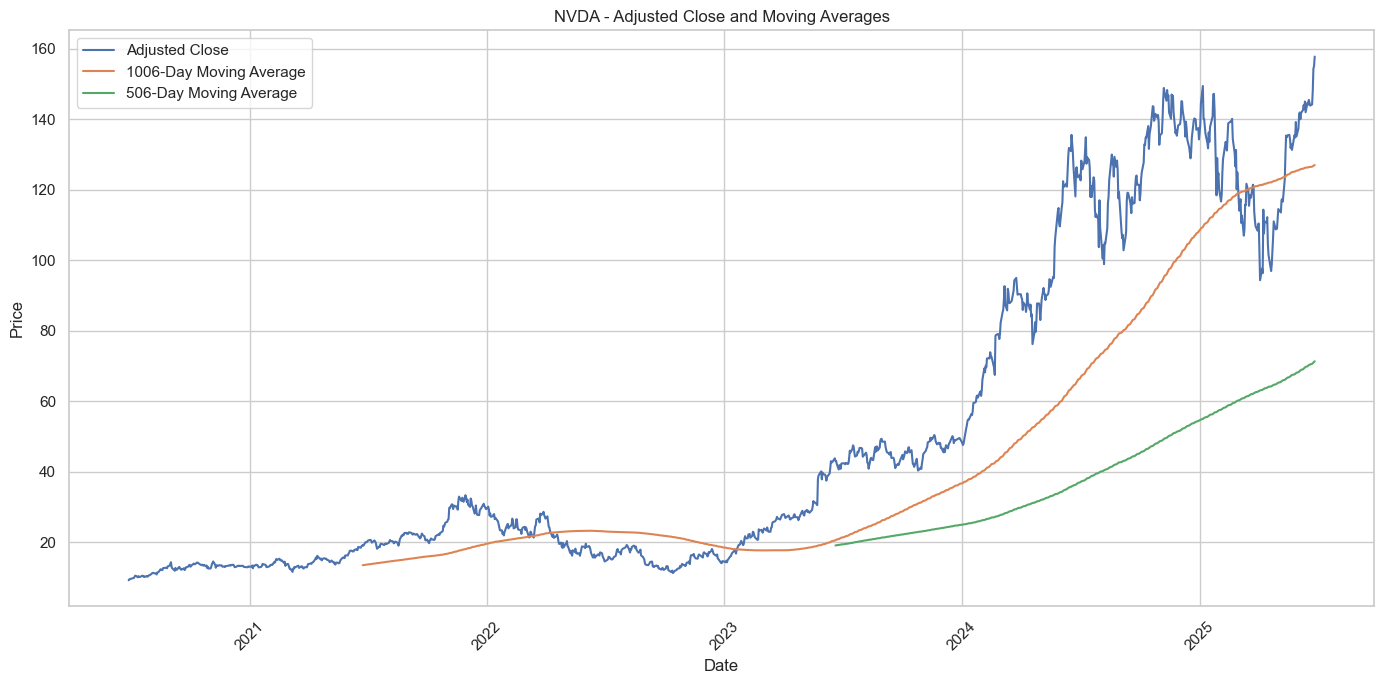

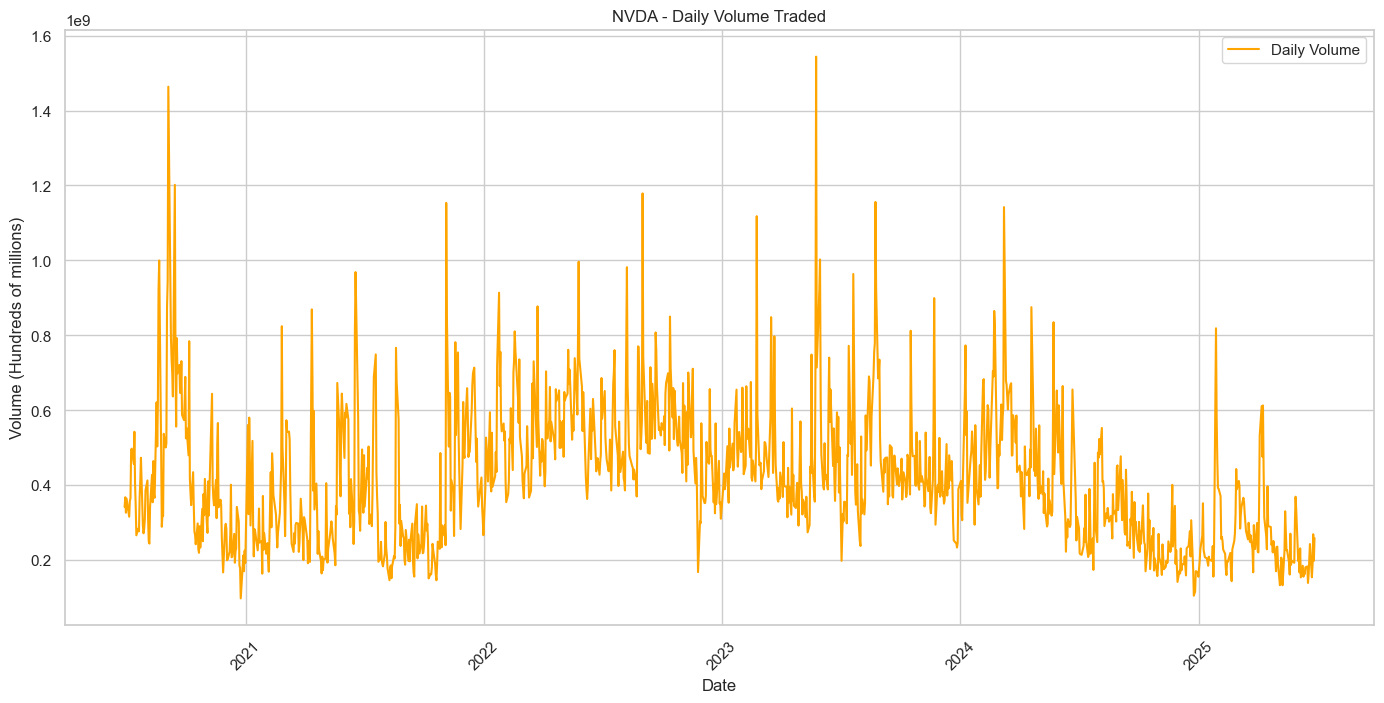

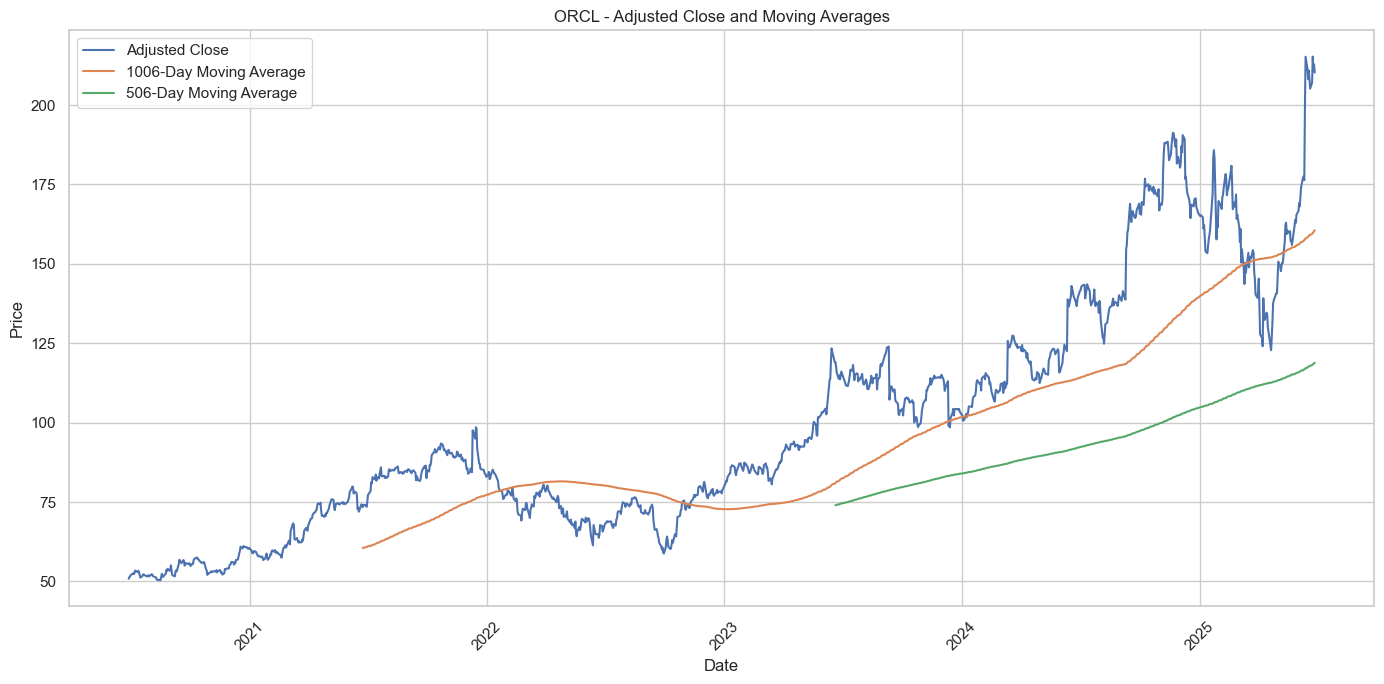

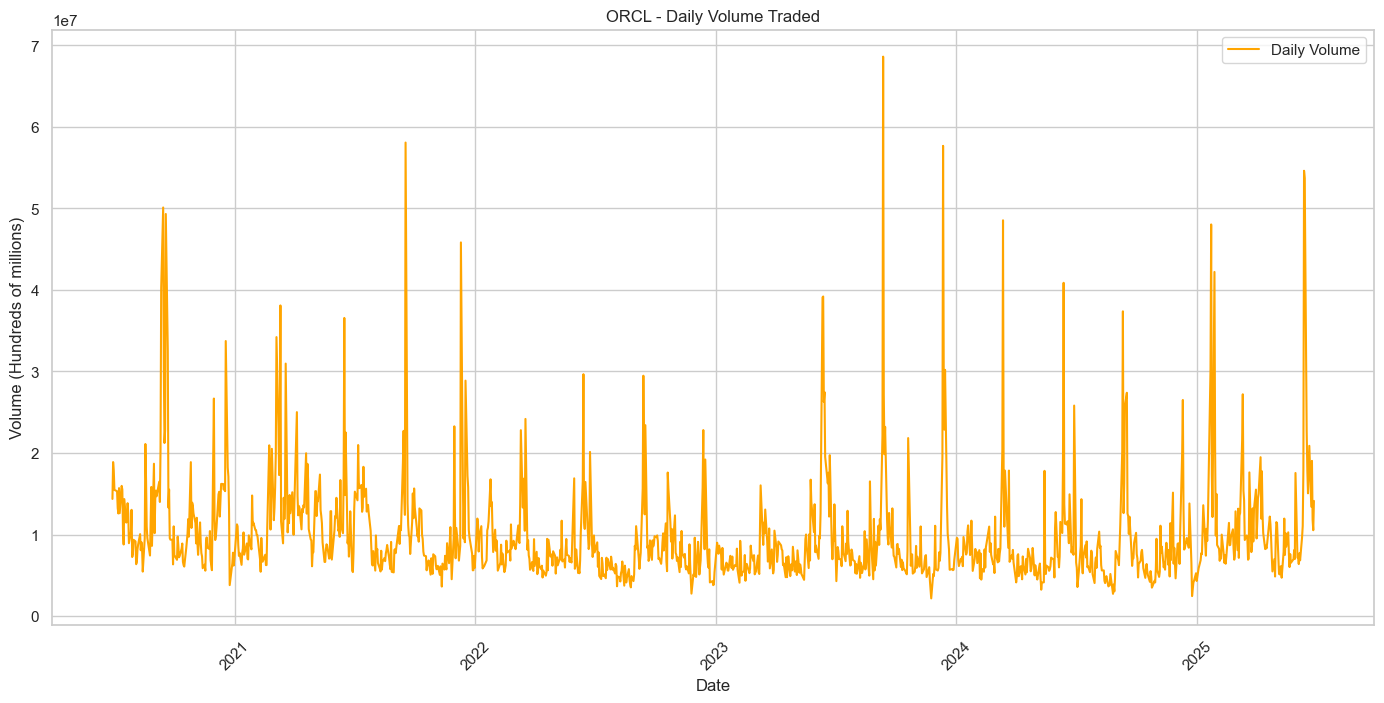

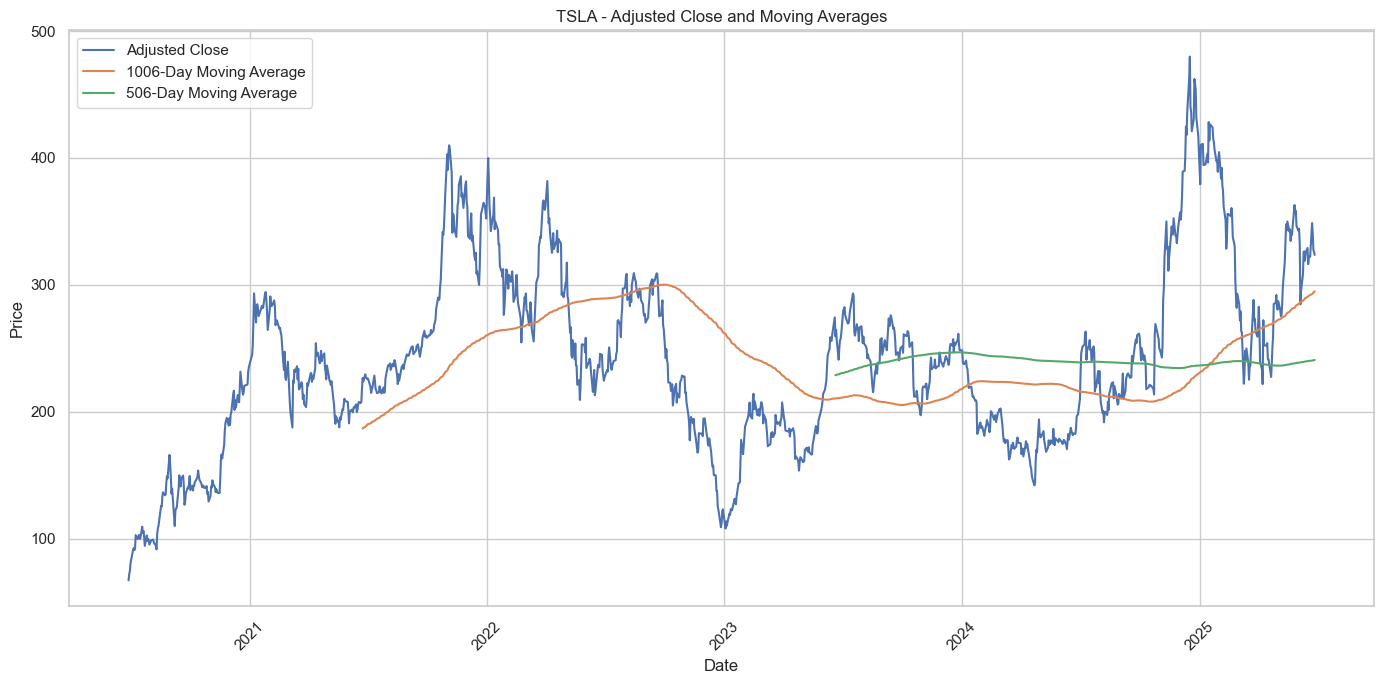

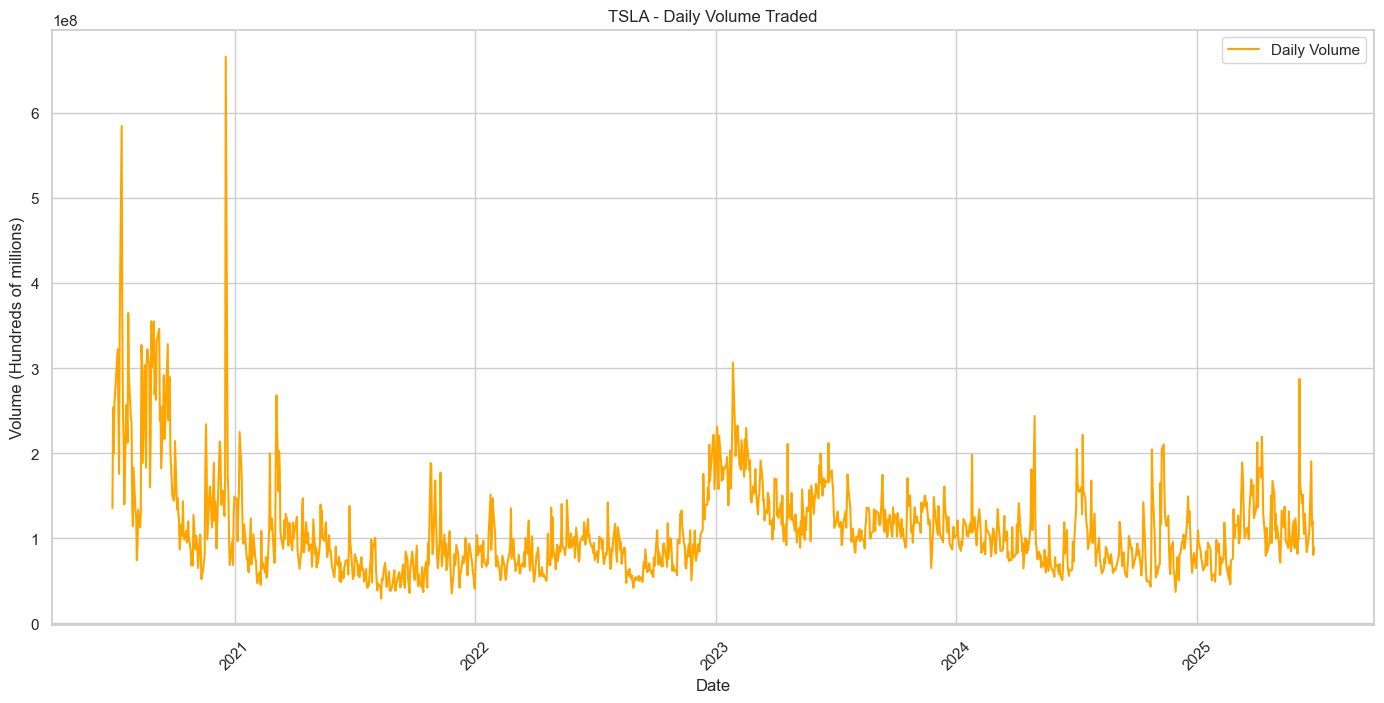

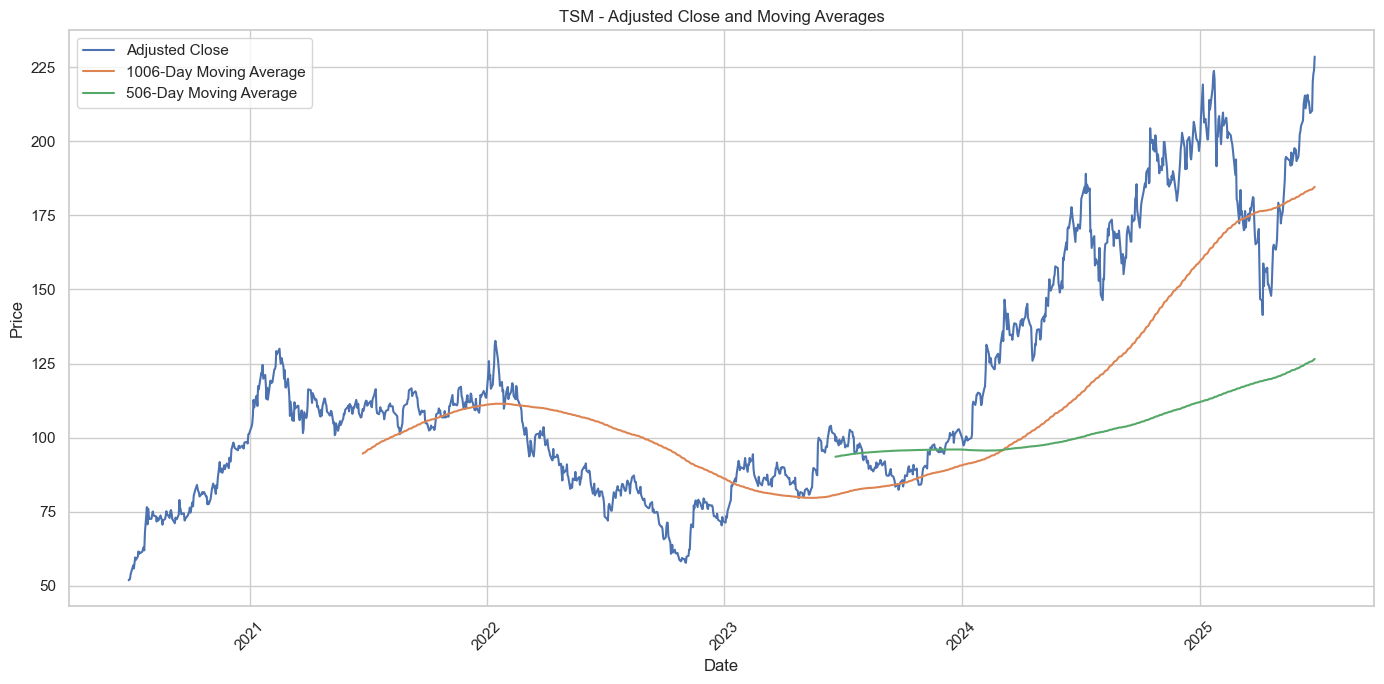

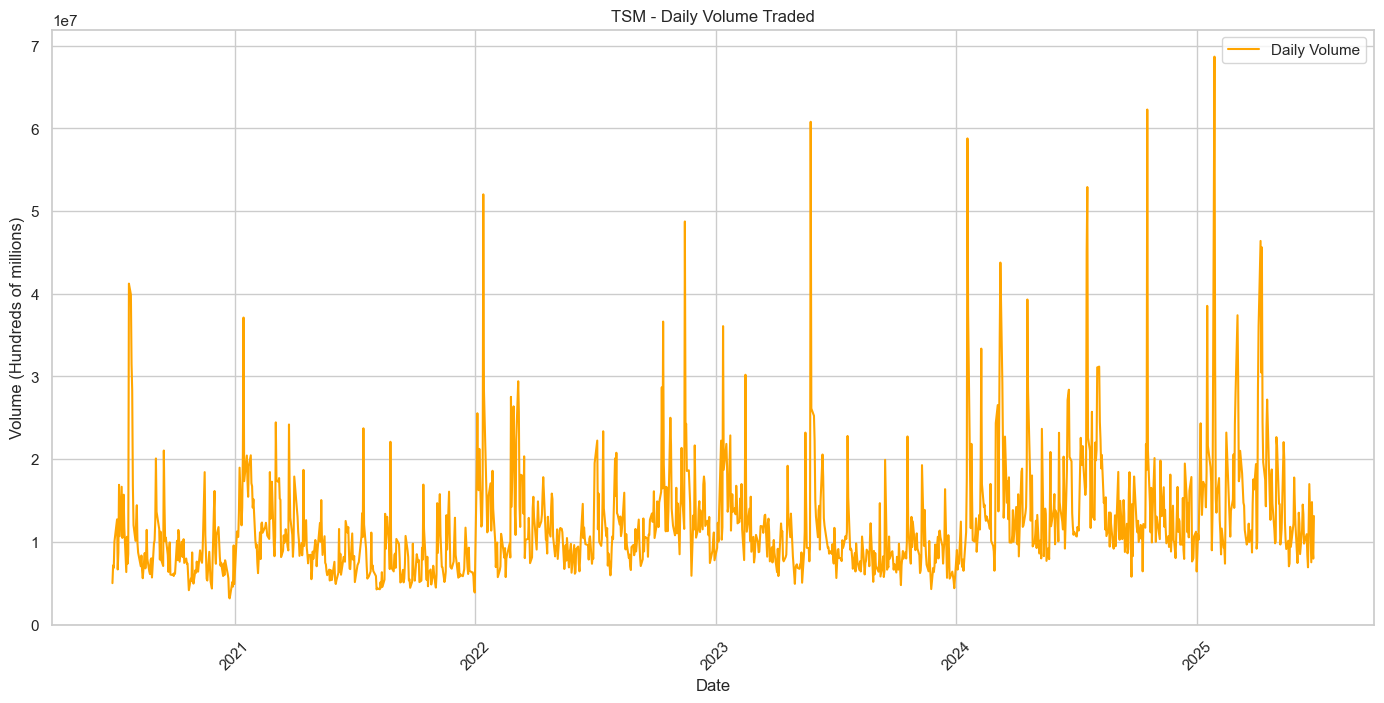

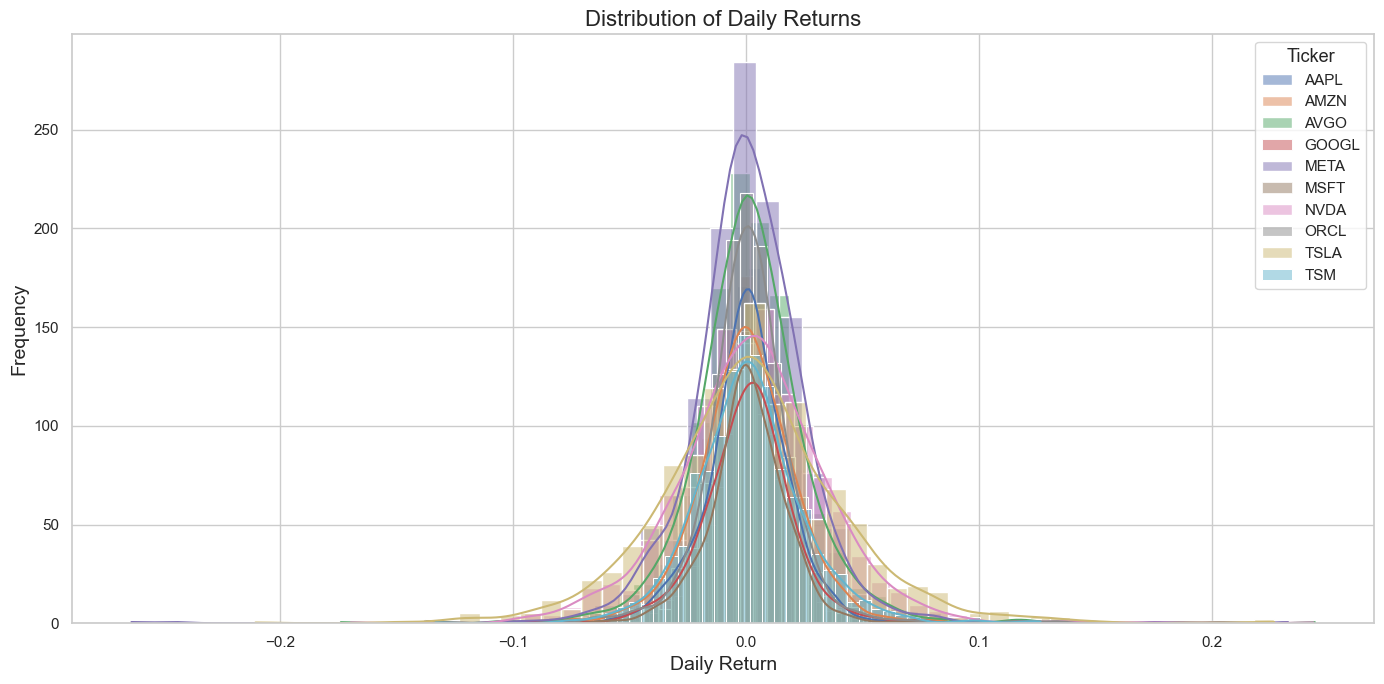

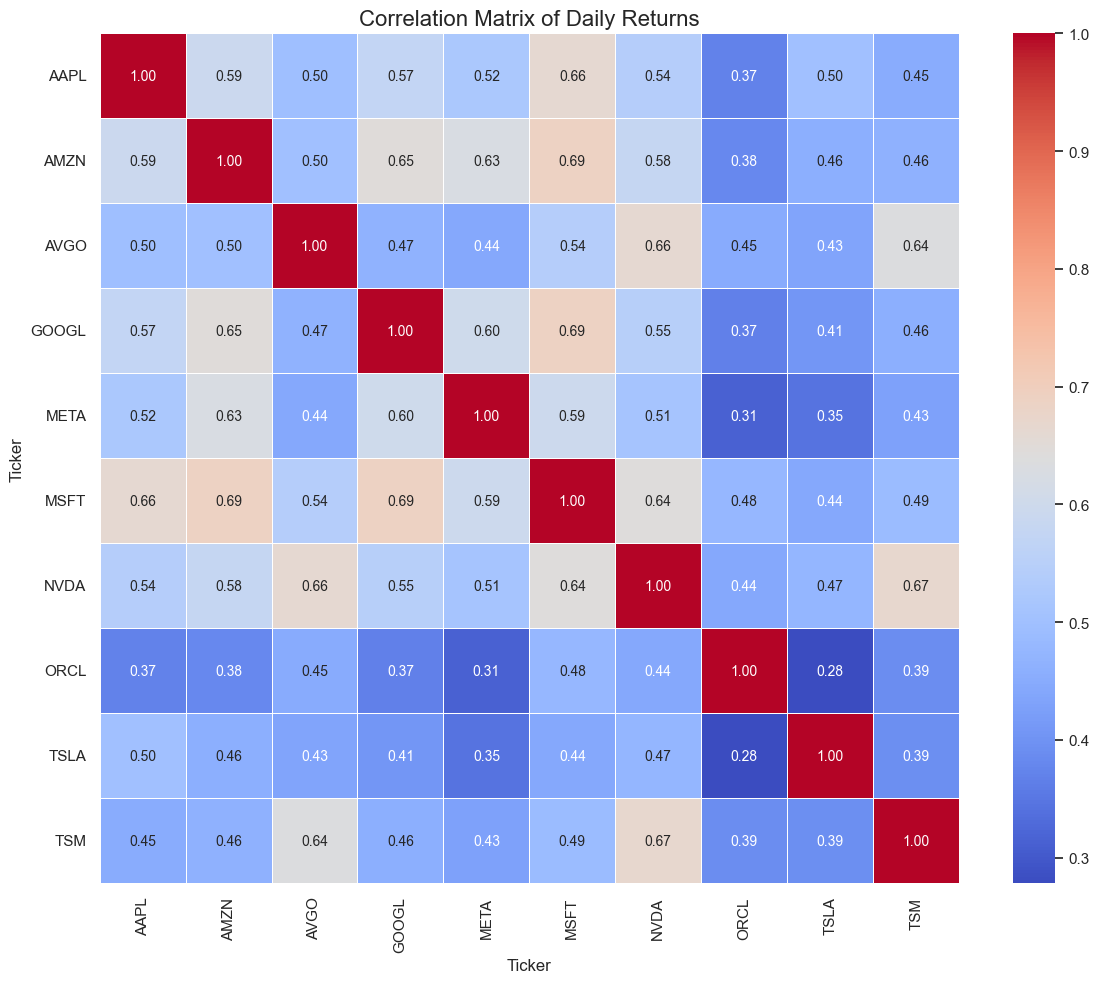

In [ ]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

short_window = 50*years
long_window = 150*years

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adjusted Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label=str(int(len(stock_data)/10)-short_window)+'-Day Moving Average')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label=str(int(len(stock_data)/10)-long_window)+'-Day Moving Average')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Volume'], color='orange', label='Daily Volume')
    plt.title(f'{ticker} - Daily Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume (Hundreds of millions)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Key Takeaways From Analysis:
- The Tariff wars in the earlier months of 2025 had a significant impact on the value of the assets
- The market recovered, although there are mixed results:
*   Remarkably, AVGO, MSFT, META, NVDA, and TSM have recovered pretty well from the tariff blows.
*   The situation is different with the other assets on the list as they continue to reel from the tariff blows and have not completely recovered. Notably, AAPL has been struggling to regain the value it lost during the time.

- The distributions are approximately normal, centred around zero, which    -- indicates that most daily returns are close to the average return. However, there are tails on both sides, which reflect occasional significant gains or losses. It is important to acknowledge this and consider it in financial decisions. Blind assumptions of the normal distribution have proven to be very risky. TSLA and NVDA appear to have slightly wider distributions, which suggests higher volatility compared to MSFT and GOOGL.


- The diversification heatmap also offers significant insights:
*   GOOGL and MSFT have a relatively strong correlation coefficient standing at 0.69. Adding a large percentage of both assets to a diversified portfolio would offer limited benefits.
*   TSLA and ORCL tell a different story; with a correlation coefficient as low as 0.28, they are good assets for a diversified portfolio.
    
    

Assumptions:
- Annual returns are estimated by multiplying mean daily return by 252 (number of trading days in a year).
- Annual volatility is estimated using the standard deviation of daily returns times the square root of 252.


In [ ]:
expected_returns = daily_returns.mean() * (252 * years)
volatility = daily_returns.std() * np.sqrt(252 * years)

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility,
    "Sharpe Ratio": expected_returns/volatility
})

print(stock_stats)

        Expected Return  Volatility  Sharpe Ratio
Ticker                                           
AAPL           1.052366    0.667350      1.576932
AMZN           0.831407    0.799286      1.040188
AVGO           2.700614    0.908608      2.972254
GOOGL          1.189664    0.694896      1.712004
META           1.699842    0.982647      1.729860
MSFT           1.143576    0.601712      1.900536
NVDA           3.552917    1.183647      3.001668
ORCL           1.688725    0.727614      2.320910
TSLA           2.605906    1.438724      1.811262
TSM            1.853878    0.856232      2.165159


'return_ = stock_stats["Expected Return"]\nvolatility = stock_stats["Volatility"]\nfinal_arr = []\nfor return__, volatility_ in zip(return_, volatility):\n    final_arr.append(return__ / volatility_)\nprint(stock_stats[stock_stats[(max(final))]])'

The Sharpe ratio is used to measure risk-adjusted return. It calculates how much return an asset gives from an asset for the risk it carries.
With the assumption that the risk-free rate is zero, the data points to Nvidia as the asset that offers the best Risk-adjusted return.

6. Efficient Frontier & Optimal Portfolio
Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:
- Calculate the expected returns and volatility for each stock.
- Generate a series of random portfolios to identify the efficient frontier.
- Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.

Simulation:
- 10,000 random portfolios generated.
For each portfolio:
- Random weights summing to 1
- Portfolio return = weighted average of asset returns
- Portfolio volatility = standard deviation using the covariance matrix
- Sharpe Ratio = Return / Volatility

Covariance Matrix:
- Calculated from daily returns and scaled to annual.
- Used for estimating portfolio-level volatility.
Visualization:
- Scatter plot of all simulated portfolios.
- X-axis: Volatility
- Y-axis: Expected Return
- Color scale: Sharpe Ratio

Optimal Portfolio:
- The portfolio with the maximum Sharpe Ratio was identified.
-Extracted its:
- Return
- Volatility
- Weights
Display:
- A DataFrame shows the weight of each asset in the optimal portfolio.

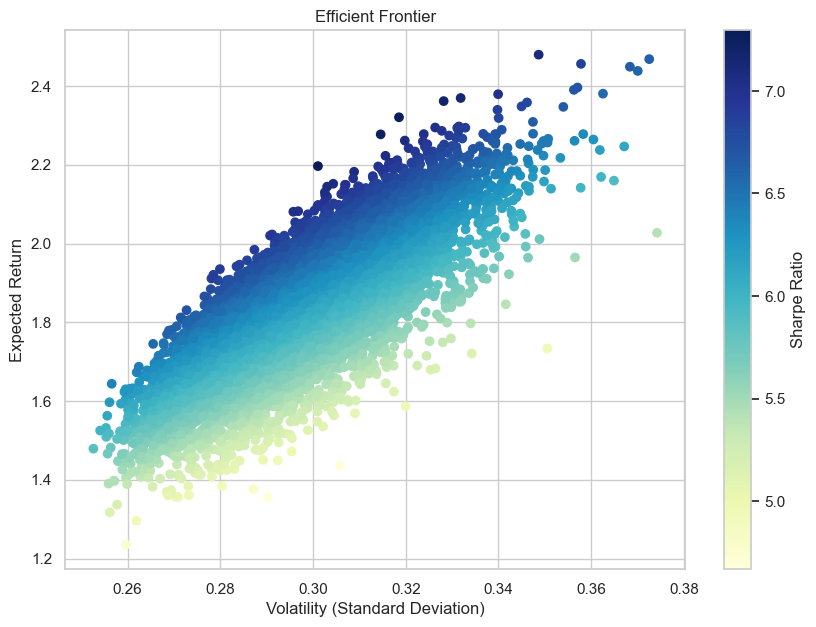

2.1965239669807444 0.3010733199288244 7.295644687148021
  Ticker     Weight
0   AAPL   3.130082
1   AMZN   6.106138
2   AVGO  11.372896
3  GOOGL   1.892364
4   META   9.784739
5   MSFT  10.766915
6   NVDA  21.217231
7   ORCL  25.440583
8   TSLA   4.905616
9    TSM   5.383436


In [ ]:
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

max_sharpe_weights = np.zeros(len(unique_tickers))


max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

print(max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights*100
})

print(portfolio_weights_df)

Based on the statistical analysis of the historical stock data of the assets, and the Sharpe Ratio analysis, the diversified portfolio with the maximum Sharpe Ratio has been derived with the recommended weight for each asset.

This project illustrates how historical stock data can be used to simulate realistic portfolios and identify optimal risk-adjusted allocations. Key takeaways:
- High correlations between some stocks imply limited diversification benefit.
- Sharpe Ratio is a critical metric for comparing risk-adjusted performance.
- The Monte Carlo simulation is very effective for visualizing the trade-off between return and volatility.